# Bitcoin Price Forecasting with Machine Learning

This notebook demonstrates the process of forecasting Bitcoin prices using machine learning techniques. We will go through the following steps:
1. Loading and exploring the dataset
2. Feature Engineering
3. Normalization
4. Splitting the data into training and testing sets
5. Creation of the LSTM Model
6. Evaluating the model
7. Forecasting future prices

Data source: `https://www.investing.com/crypto/bitcoin/historical-data`

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error
import joblib

import warnings
warnings.filterwarnings("ignore")

## Step 1: Load and Explore the Data

First, we'll load the dataset and explore its structure.

In [28]:
# Load and sort the data
data = pd.read_csv('./datasets/coin_Bitcoin_full.csv', parse_dates=['Date'], index_col='Date')
data = data.sort_index()

## Step 2: Feature Engineering

We can create additional features such as:
- Moving averages (e.g., 7-day, 14-day).
- Price changes (daily percentage change).
- Volatility (rolling standard deviation).

In [29]:
# Feature engineering
data['7_day_MA'] = data['Close'].rolling(window=7).mean()
data['14_day_MA'] = data['Close'].rolling(window=14).mean()
data['30_day_MA'] = data['Close'].rolling(window=30).mean()
data['Daily_Change'] = data['Close'].pct_change()
data['Volatility'] = data['Close'].rolling(window=7).std()

# Drop the NaN values created by rolling windows
data = data.dropna()

In [30]:
# Select features and target variable
features = data[['Close', '7_day_MA', '14_day_MA', '30_day_MA', 'Daily_Change', 'Volatility']]
target = data['Close']

## Step 3: Normalization of the data
Next, we'll Normalize the data then split it 80/20 as training and testing sets.

In [31]:
# Separate scaler for Close prices
close_scaler = MinMaxScaler()
scaled_close = close_scaler.fit_transform(target.values.reshape(-1, 1))

# Normalization for other features
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

## Step 4: Train-Test Split
We will split the data into training and testing sets. We'll use the last year in the dataset for testing.

In [32]:
# Split the data into training and testing sets
train_size = int(len(scaled_features) * 0.8)
train_features, test_features = scaled_features[:train_size], scaled_features[train_size:]
train_close, test_close = scaled_close[:train_size], scaled_close[train_size:]

## Step 5: Creation of the LSTM Model

In [33]:
# Reshape data for LSTM model
train_features = train_features.reshape((train_features.shape[0], 1, train_features.shape[1]))
test_features = test_features.reshape((test_features.shape[0], 1, test_features.shape[1]))

In [34]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(1, train_features.shape[2])))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(train_features, train_close, epochs=20, batch_size=32)

Epoch 1/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0339
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.6981e-04
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.8906e-04
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.4983e-04
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.9911e-04
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.7253e-04
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6027e-04
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8379e-04
Epoch 9/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0597e-04
Epoch 10/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0586e-04
Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8.5246e-05
Epoch 12/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.0127e-05
Epoch 13/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.2450e-05
Epoch 14/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.1743e-05
Epoch

## Step 6: Evaluate the Model
We will evaluate the model by predicting the Bitcoin prices on the test set and calculating the RMSE. We will also visualize the actual vs. predicted prices from both train and test.

In [35]:
# Predict Close prices
predicted_scaled_close = model.predict(test_features)

# Inverse transform the predicted Close prices
predicted_close = close_scaler.inverse_transform(predicted_scaled_close)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(test_close, predicted_scaled_close))
print(f"Root Mean Squared Error: {rmse}")

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Root Mean Squared Error: 0.00645949356132721


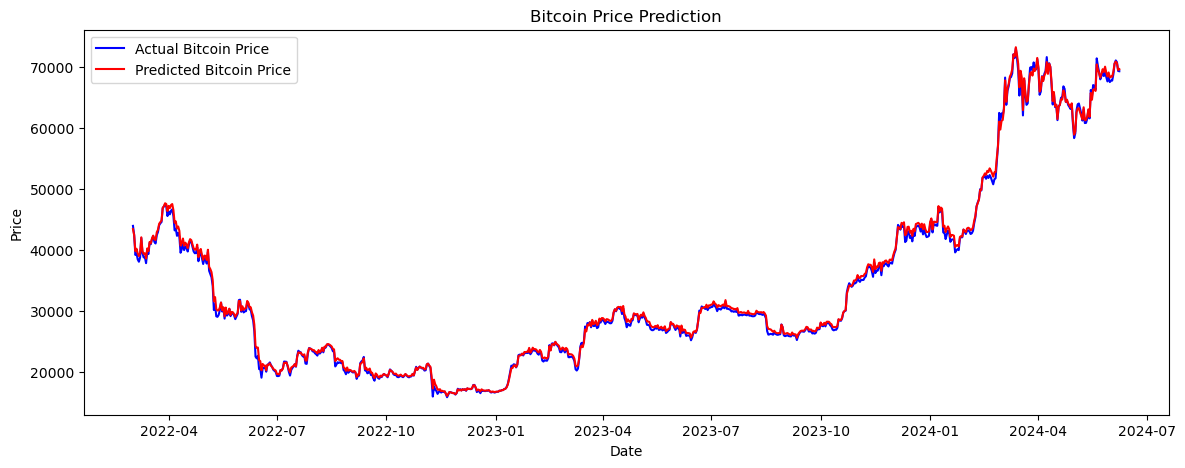

In [36]:
# Plot actual vs predicted prices
plt.figure(figsize=(14, 5))
plt.plot(data.index[train_size:], close_scaler.inverse_transform(test_close), color='blue', label='Actual Bitcoin Price')
plt.plot(data.index[train_size:], predicted_close, color='red', label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## Step 7: Forecast Future Prices
Finally, we will forecast the Bitcoin prices for the next year using the trained model.

In [37]:
# Save the model
model.save('./models/bitcoin_price_prediction.h5')

# Save the scalers
joblib.dump(close_scaler, './models/close_scaler.pkl')
joblib.dump(scaler, './models/scaler.pkl')

# Save the data
data.to_csv('./datasets/processed_data.csv')

In [51]:
# Apply the model to predict future prices for the next 90 days
future_features = features[-90:]
future_features = scaler.transform(future_features)
future_features = future_features.reshape((future_features.shape[0], 1, future_features.shape[1]))
future_close = model.predict(future_features)
future_close = close_scaler.inverse_transform(future_close)

# Create a DataFrame for the future prices
future_dates = pd.date_range(start=data.index[-1], periods=91, freq='D')[1:]
future_prices = pd.DataFrame(future_close, index=future_dates, columns=['Close'])
future_prices.head()

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,Close
2024-06-09,72074.140625
2024-06-10,71731.601562
2024-06-11,73251.960938
2024-06-12,71990.632812
2024-06-13,70522.390625


In [52]:
# Apply the model to predict future prices for the next 60 days
future_features = features[-60:]
future_features = scaler.transform(future_features)
future_features = future_features.reshape((future_features.shape[0], 1, future_features.shape[1]))
future_close = model.predict(future_features)
future_close = close_scaler.inverse_transform(future_close)

# Create a DataFrame for the future prices
future_dates = pd.date_range(start=data.index[-1], periods=61, freq='D')[1:]
future_prices = pd.DataFrame(future_close, index=future_dates, columns=['Close'])
future_prices.head()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


,Close
2024-06-09,70552.570312
2024-06-10,70033.164062
2024-06-11,67602.773438
2024-06-12,64405.652344
2024-06-13,65895.703125


In [53]:
# Apply the model to predict future prices for the next 30 days
future_features = features[-30:]
future_features = scaler.transform(future_features)
future_features = future_features.reshape((future_features.shape[0], 1, future_features.shape[1]))
future_close = model.predict(future_features)
future_close = close_scaler.inverse_transform(future_close)

# Create a DataFrame for the future prices
future_dates = pd.date_range(start=data.index[-1], periods=31, freq='D')[1:]
future_prices = pd.DataFrame(future_close, index=future_dates, columns=['Close'])
future_prices.head()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


,Close
2024-06-09,61254.109375
2024-06-10,61313.070312
2024-06-11,61857.023438
2024-06-12,63048.242188
2024-06-13,61821.203125


In this final step, we generate future dates and use the trained model to predict Bitcoin prices for the next year. We also plot the predicted future prices to visualize the forecast.

Parameter and Feature adjustment can be further applied to imporve the model's performance.

We note that the first few days in the `90` and `60` days predictions are close to the actual prices while the more we reduce the `future_features` prediction size we note prices further from the actual predictions.

It is also noted that in all prediction periods the prices drop significantly over time in an unusual manner.